In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import yt

from galaxy_analysis.gizmo import yield_model
from galaxy_analysis.utilities import cy_convert_abundances as ca
#from galaxy_analysis.utilities import convert_abundances as ca
from galaxy_analysis.plot.plot_styles import *




from scipy.stats import ks_2samp

In [3]:
#
# How to generate yields:
#
simulation = 'm12q'
wdir = "/home/aemerick/work/gizmo_runs/m12q_res5700_test/"

#simulation = 'm10q_fiducial_post_constFB'
#wdir = "/home/aemerick/work/gizmo_runs/m10q_test/full_fire_contFB/"

#simulation = 'm10q_fiducial_post'
#wdir = "/home/aemerick/work/gizmo_runs/m10q_test/full_fire_fiducial/"

age_bins = yield_model.get_bins(config_file = wdir + "/gizmo.out", binfile = wdir+"/age_bins.txt")


Z = 1.0E-5
FIRE_Z_scaling = True
age_is_fraction = True

total_yields = yield_model.construct_yields(age_bins/1000.0, # pass bins as Gyr, Z = Z,
                                    Z = Z, yieldtype = 'total', FIRE_Z_scaling=FIRE_Z_scaling)



# load ds and generate yields

N yield in SNII is less than zero due to FIRE scaling
N yield in SNIA is negative


In [4]:
#np.log10(ds0.hubble_constant)

In [5]:
ds0     = yt.load(wdir + 'output/snapshot_000.hdf5')
data0   = ds0.all_data()
fields = ds0.field_list

# generate
yield_model.generate_metal_fields(ds0,_agebins=age_bins,_yields=total_yields, age_is_fraction=age_is_fraction)
#yield_model._generate_star_metal_fields(ds0, _agebins = age_bins, _yields = total_yields)

metals = np.unique([x[1] for x in ds0.field_list if ((x[0] == 'PartType0') and ('Metal' in x[1]))])

initial_abundance=np.zeros(np.size(metals))
for i in np.arange(np.size(initial_abundance)):
    z = data0[('PartType0','Metallicity_%02i'%(i))]
    print("%5.5E %5.5E %5.5E"%(np.min(z),np.max(z),np.average(z)))

    initial_abundance[i] = np.average(z).value
    
logH = np.log10(ds0.hubble_constant)

2.00000E-06 2.00000E-06 2.00000E-06
2.50003E-01 2.50003E-01 2.50003E-01
3.26000E-07 3.26000E-07 3.26000E-07
1.32000E-07 1.32000E-07 1.32000E-07
8.65000E-07 8.65000E-07 8.65000E-07
2.22000E-07 2.22000E-07 2.22000E-07
9.31000E-08 9.31000E-08 9.31000E-08
1.08000E-07 1.08000E-07 1.08000E-07
6.44000E-08 6.44000E-08 6.44000E-08
1.01000E-08 1.01000E-08 1.01000E-08
1.73000E-07 1.73000E-07 1.73000E-07
0.00000E+00 0.00000E+00 0.00000E+00
0.00000E+00 0.00000E+00 0.00000E+00
0.00000E+00 0.00000E+00 0.00000E+00
0.00000E+00 0.00000E+00 0.00000E+00
0.00000E+00 0.00000E+00 0.00000E+00
0.00000E+00 0.00000E+00 0.00000E+00
0.00000E+00 0.00000E+00 0.00000E+00
0.00000E+00 0.00000E+00 0.00000E+00
0.00000E+00 0.00000E+00 0.00000E+00
0.00000E+00 0.00000E+00 0.00000E+00
0.00000E+00 0.00000E+00 0.00000E+00
0.00000E+00 0.00000E+00 0.00000E+00
0.00000E+00 0.00000E+00 0.00000E+00
0.00000E+00 0.00000E+00 0.00000E+00
0.00000E+00 0.00000E+00 0.00000E+00
0.00000E+00 0.00000E+00 0.00000E+00
0.00000E+00 0.00000E+00 0.00

In [6]:
ds     = yt.load(wdir + 'output/snapshot_124.hdf5')
data   = ds.all_data()
fields = ds.field_list

# generate
yield_model.generate_metal_fields(ds,_agebins=age_bins,_yields=total_yields,age_is_fraction=age_is_fraction)
yield_model._generate_star_metal_fields(ds, _agebins = age_bins, _yields = total_yields,age_is_fraction=age_is_fraction)

ptypes = np.unique([x[0] for x in ds.field_list])
metals = np.unique([x[1] for x in ds.field_list if ((x[0] == 'PartType0') and ('Metal' in x[1]))])

print(np.min(data[('PartType0','particle_mass')].to('Msun')))
M_norm = np.min(data[('PartType0','particle_mass')].to('Msun') )


56538.21342723229 Msun


In [7]:
def _get_abund(e,dat,ptype='star'):
    
    if ptype == 'star':
        ptype = "PartType4"
    elif ptype == 'gas':
        ptype = "PartType0"
    
    
    
    if e == "H":
        return 1.0 - dat[(ptype,"Metallicity_00")] - dat[(ptype,"Metallicity_01")]
    else:
        ei = yield_model.elements.index(e)
        return dat[(ptype,"Metallicity_%02i"%(ei))]
    
#
# Now plot for age tracers
#
littleh = ds0.hubble_constant

def _get_age_abund(e,dat,ptype='star'):
    
    if ptype == 'star':
        ptype = "PartType4"
    elif ptype == 'gas':
        ptype = "PartType0"
    
    if e == "H":
        # H_frac = 1.0 - dat[(ptype,"Metallicity_00")] - dat[(ptype,"Metallicity_01")]
        M = dat[(ptype,'particle_mass')].to('Msun')
        
            
        H_frac = M*(1.0-initial_abundance[0]-initial_abundance[1])-\
                   dat[('all',ptype+'_Total_mass')] / littleh - dat[('all',ptype+'_He_mass')] / littleh
        H_frac = H_frac / dat[(ptype,'particle_mass')].to('Msun')
        
        return H_frac
    else:
        ei = yield_model.elements.index(e)
        # very bad!!!
        mass = dat[('all', ptype + '_' + e + '_mass')].to('Msun') / littleh
        norm = dat[(ptype,'particle_mass')].to('Msun')
       # M_norm # (16752.063237698454*yt.units.Msun)
        
        Z = mass / norm
        
        Z = Z + initial_abundance[yield_model.elements.index(e)]
        
        return Z# mass/norm #+ initial_abundance[yield_model.elements.index(e)]
        
def get_ratio(e1,e2,dat,age=True):
    if age:
        vals1 = _get_age_abund(e1,dat)
        vals2 = _get_age_abund(e2,dat)
    else:
        vals1 = _get_abund(e1,dat)
        vals2 = _get_abund(e2,dat)
    return ca.abundance_ratio_array(e1,vals1,e2,vals2,
                                  input_type="abundance")    

-1.8475379983343 0.09320162218832029
-2.1370122499682855 2.4429350680447404


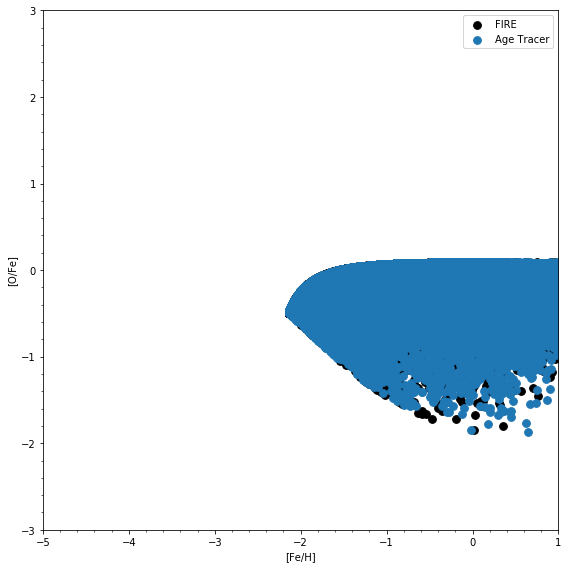

In [7]:
#
# Lets try and plot O / Fe vs Fe / H
#   for the fiducial fire stuff

# elements
y1e,y2e = "O", "Fe"
x1e,x2e = "Fe", "H"
#

#y1, y2 = yield_model.elements.index(y1e), yield_model.elements.index(y2e)
#x1, x2 = yield_model.elements.index(x1e), yield_model.elements.index(x2e)

    
y1_vals = _get_abund(y1e,data)
y2_vals = _get_abund(y2e,data)
y1y2    = ca.abundance_ratio_array(y1e, y1_vals, y2e, y2_vals,
                                  input_type="abundance")
x1_vals = _get_abund(x1e,data)
x2_vals = _get_abund(x2e,data)
x1x2    = ca.abundance_ratio_array(x1e, x1_vals, x2e, x2_vals,
                                   input_type = "abundance")

fig, ax = plt.subplots()
fig.set_size_inches(8,8)

ax.scatter(x1x2, y1y2, color = "black", s = 60, marker="o", label = "FIRE")
    
y1_vals = _get_age_abund(y1e,data)
y2_vals = _get_age_abund(y2e,data)
age_y1y2    = ca.abundance_ratio_array(y1e, y1_vals, y2e, y2_vals,
                                  input_type="abundance")
x1_vals = _get_age_abund(x1e,data)
x2_vals = _get_age_abund(x2e,data)
age_x1x2    = ca.abundance_ratio_array(x1e, x1_vals, x2e, x2_vals,
                                   input_type = "abundance")
print(np.min(y1y2),np.max(y1y2))
print(np.min(x1x2),np.max(x1x2))


ax.scatter(age_x1x2, age_y1y2, color = "C0", s = 60, marker="o", label = "Age Tracer")


ax.set_ylabel("[" + y1e + "/" + y2e + "]")
ax.set_xlabel("[" + x1e + "/" + x2e + "]")

ax.legend(loc='best')

ax.set_xlim(-5,1)
ax.set_ylim(-3,3)

plt.minorticks_on()
plt.tight_layout()

In [8]:
x1e = 'O'
x2e = 'H'

def MDF(x1e,x2e,data,rmin=None,rmax=None,dbin=0.25, age=True, ptype='star', diff = False, absval=False):
    """
    Return MDF
    """
    
    if (absval) and (not diff):
        print("Are you sure you want to take the absolute value of hte abundance if it is not a diff?")
        raise ValueError
    
    
    if diff:
        x1_vals_age = _get_age_abund(x1e,data,ptype=ptype)
        x2_vals_age = _get_age_abund(x2e,data,ptype=ptype)        

        x1_vals = _get_abund(x1e,data,ptype=ptype)
        x2_vals = _get_abund(x2e,data,ptype=ptype)
        
        abund_age  = ca.abundance_ratio_array(x1e, x1_vals_age, x2e, x2_vals_age,
                                      input_type="abundance")
        abund  = ca.abundance_ratio_array(x1e, x1_vals, x2e, x2_vals,
                                      input_type="abundance")
        
        cutvals1 = _get_abund('O',data,ptype=ptype)
        cutvals2 = _get_abund('H',data,ptype=ptype)       
        
        H_cut = ca.abundance_ratio_array('O',cutvals1,'H',cutvals2,input_type='abundance')
        
        abund     = abund[ (H_cut > -2.6)]        
        abund_age = abund_age[ (H_cut > -2.6)]
        
        
        if absval:
            abund = np.abs(abund - abund_age) # diff 
        
    else:
        if age:
            x1_vals = _get_age_abund(x1e,data,ptype=ptype)
            x2_vals = _get_age_abund(x2e,data,ptype=ptype)
        else:
            x1_vals = _get_abund(x1e,data,ptype=ptype)
            x2_vals = _get_abund(x2e,data,ptype=ptype)
        
        abund  = ca.abundance_ratio_array(x1e, x1_vals, x2e, x2_vals,
                                      input_type="abundance")        
        if ptype == 'gas':
            cutvals1 = _get_abund('O',data,ptype=ptype)
            cutvals2 = _get_abund('H',data,ptype=ptype)       
        
            H_cut = ca.abundance_ratio_array('O',cutvals1,'H',cutvals2,input_type='abundance')
        
            abund     = abund[ (H_cut > -2.6)]        
            
        

    
    if rmin is None:
        rmin = np.min(abund)
    if rmax is None:
        rmax = np.max(abund)

    nbins = int((rmax - rmin)/dbin)
    
    hist, bins = np.histogram(abund, bins = nbins, range = (rmin,rmax))
    hist2 = np.ones(np.size(hist)+1)
    hist2[:-1] = hist
    hist2[-1] = hist2[-2]
    
    
    stats = {'median' : np.median(abund), 'mean' : np.average(abund),
             'Q1'     : np.quantile(abund,0.25), 'Q3' : np.quantile(abund,0.75),
             'IQR'    : np.quantile(abund,0.75) - np.quantile(abund,0.25),
             'std'    : np.std(abund)}
    
    # compute fraction < a given offset
    if diff:
        stats['0.2dex']   = np.size( abund[ np.abs(abund) < 0.2  ]) / (1.0*np.size(abund))
        stats['0.1dex']   = np.size( abund[ np.abs(abund) < 0.1  ]) / (1.0*np.size(abund))
        stats['0.05dex']  = np.size( abund[ np.abs(abund) < 0.05 ]) / (1.0*np.size(abund))
        stats['0.02dex']  = np.size( abund[ np.abs(abund) < 0.02 ]) / (1.0*np.size(abund))
        stats['0.01dex']  = np.size( abund[ np.abs(abund) < 0.01 ]) / (1.0*np.size(abund))
        stats['0.005dex'] = np.size( abund[ np.abs(abund) < 0.005]) / (1.0*np.size(abund))
   
    
    if diff:
        return bins,hist2,stats
    else:
        return bins, hist2



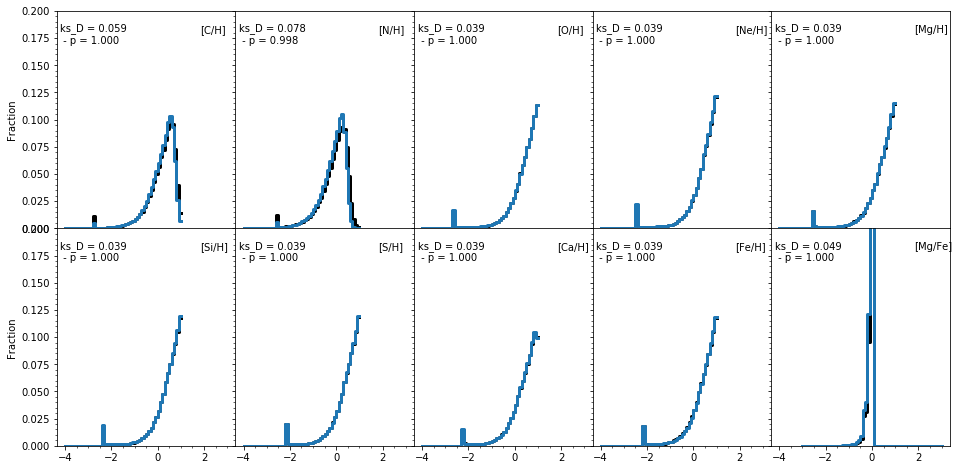

In [9]:

fig,ax = plt.subplots(2,5,sharey=True,sharex=True)
fig.set_size_inches(16,8)
fig.subplots_adjust(wspace=0,hspace=0)

xy = (0.8,0.90)

def plot_ax(ax, e1, e2, data,db=0.1,amin=-4,amax=1):
    
    bins, hist1 = MDF(e1,e2,data,amin,amax,age=False,dbin=db)
    ax.step(bins, hist1/(1.0*np.sum(hist1)), where='post',lw=3,color='black')
    bins, hist2 = MDF(e1,e2,data,amin,amax,age=True,dbin=db)
    ax.step(bins, hist2/(1.0*np.sum(hist1)), where='post',lw=3,color='C0')
    ax.annotate('[' + e1 + '/'+ e2 + ']', xy=xy,xycoords='axes fraction')
    
    ksval = ks_2samp(hist1,hist2)
    
    ax.annotate('ks_D = %0.3f \n - p = %.3f'%(ksval[0],ksval[1]),xy=(0.02,xy[1]-0.05),xycoords='axes fraction')
    
    return

plot_ax(ax[(0,0)],'C','H',data)
plot_ax(ax[(0,1)],'N','H',data)
plot_ax(ax[(0,2)],'O','H',data)
plot_ax(ax[(0,3)],'Ne','H',data)
plot_ax(ax[(0,4)],'Mg','H',data)

plot_ax(ax[(1,0)],'Si','H',data)
plot_ax(ax[(1,1)],'S','H',data)
plot_ax(ax[(1,2)],'Ca','H',data)
plot_ax(ax[(1,3)],'Fe','H',data)


plot_ax(ax[(1,4)],'Mg','Fe',data,amin=-3,amax=3)

for ax1 in ax:
    for ax2 in ax1:
        ax2.set_ylim(0,0.2)
ax[(0,0)].set_ylabel('Fraction')
ax[(1,0)].set_ylabel('Fraction')

plt.minorticks_on()


outname = simulation + '_stellar_MDFs.png'
fig.savefig(outname)

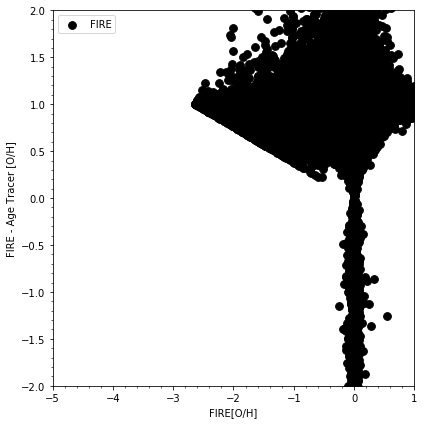

In [9]:
#
# Lets try and plot O / Fe vs Fe / H
#   for the fiducial fire stuff

# elements
y1e,y2e = "O", "H"
x1e,x2e = "O","H"
#

#y1, y2 = yield_model.elements.index(y1e), yield_model.elements.index(y2e)
#x1, x2 = yield_model.elements.index(x1e), yield_model.elements.index(x2e)

    
y1_vals = _get_abund(y1e,data)
y2_vals = _get_abund(y2e,data)
y1y2    = ca.abundance_ratio_array(y1e, y1_vals, y2e, y2_vals,
                                  input_type="abundance")
x1_vals = _get_age_abund(x1e,data)
x2_vals = _get_age_abund(x2e,data)
x1x2    = ca.abundance_ratio_array(x1e, x1_vals, x2e, x2_vals,
                                   input_type = "abundance")

fig, ax = plt.subplots()
fig.set_size_inches(6,6)

ax.scatter(y1y2, y1y2/x1x2, color = "black", s = 60, marker="o", label = "FIRE")

ax.set_ylabel("FIRE - Age Tracer [" + y1e + "/" + y2e + "]")
ax.set_xlabel("FIRE[" + x1e + "/" + x2e + "]")

ax.legend(loc='best')

ax.set_xlim(-5,1)
#ax.set_ylim(ax.get_xlim())
ax.set_ylim(-2,2)
#ax.plot([-100,100],[-100,100])

plt.minorticks_on()
plt.tight_layout()

In [10]:
x = y1_vals - x1_vals

print(np.min(x),np.max(x),np.average(x))

-0.0033361075840137276 dimensionless 0.004956438565846995 dimensionless 2.0313989112468403e-06 dimensionless



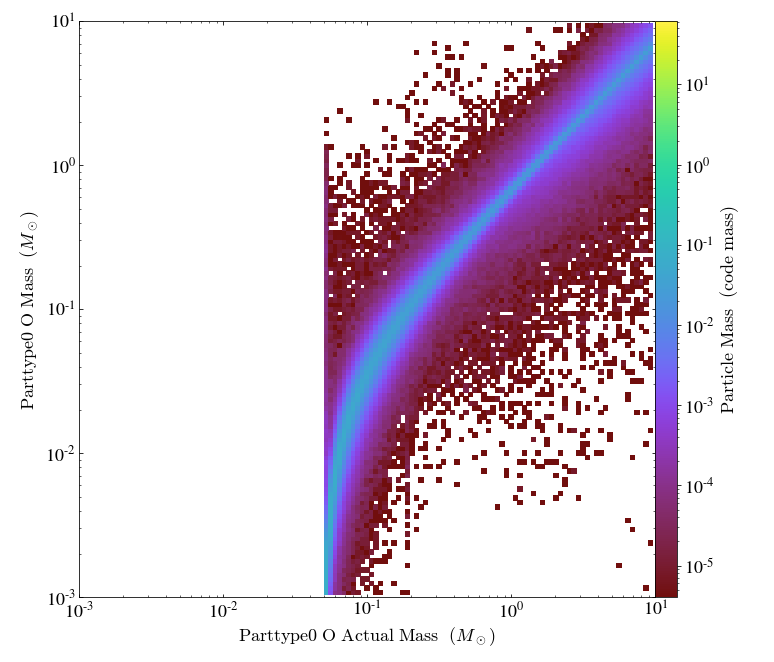

In [11]:
pp = yt.PhasePlot(ds, 'PartType0_O_actual_mass', 'PartType0_O_mass', 
                 ('PartType0','particle_mass'), weight_field=None)
pp.set_xlim(1.0E-3,10.)
pp.set_ylim(1.0E-3,10.)

pp.set_log('PartType0_O_actual_mass',True)
pp.set_log('PartType0_O_mass',True)



KeyboardInterrupt: 

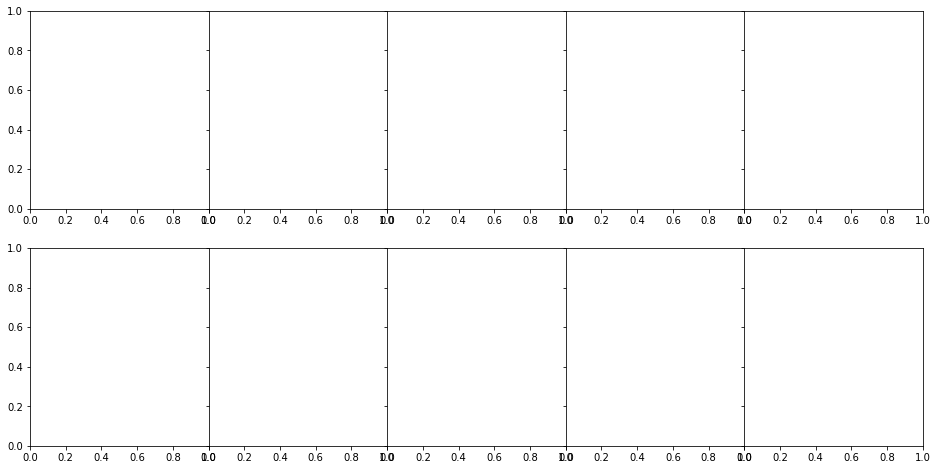

In [12]:
x1e = 'O'
x2e = 'H'


amin,amax = -4,1


fig,ax = plt.subplots(2,5,sharey=True)
fig.set_size_inches(16,8)

fig.subplots_adjust(wspace=0)

#'C', 'N', 'O', 'Ne', 'Mg', 'Si', 'S', 'Ca', 'Fe
bins,hist = MDF('C','H',data,amin,amax,age=False,ptype='gas')
ax[(0,0)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'black')
bins,hist = MDF('C','H',data,amin,amax,age=True,ptype='gas')
ax[(0,0)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
ax[(0,0)].set_xlabel('[C/H]')


bins,hist = MDF('N','H',data,amin,amax,age=False,ptype='gas')
ax[(0,1)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'black')
bins,hist = MDF('N','H',data,amin,amax,age=True,ptype='gas')
ax[(0,1)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
ax[(0,1)].set_xlabel('[N/H]')

bins,hist = MDF('O','H',data,amin,amax,age=False,ptype='gas')
ax[(0,2)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'black')
bins,hist = MDF('O','H',data,amin,amax,age=True,ptype='gas')
ax[(0,2)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
ax[(0,2)].set_xlabel('[O/H]')


bins,hist = MDF('Ne','H',data,amin,amax,age=False,ptype='gas')
ax[(0,3)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'black')
bins,hist = MDF('Ne','H',data,amin,amax,age=True,ptype='gas')
ax[(0,3)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
ax[(0,3)].set_xlabel('[Ne/H]')

bins,hist = MDF('Mg','H',data,amin,amax,age=False,ptype='gas')
ax[(0,4)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'black')
bins,hist = MDF('Mg','H',data,amin,amax,age=True,ptype='gas')
ax[(0,4)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
ax[(0,4)].set_xlabel('[Mg/H]')

bins,hist = MDF('Si','H',data,amin,amax,age=False,ptype='gas')
ax[(1,0)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'black')
bins,hist = MDF('Si','H',data,amin,amax,age=True,ptype='gas')
ax[(1,0)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
ax[(1,0)].set_xlabel('[Si/H]')

bins,hist = MDF('S','H',data,amin,amax,age=False,ptype='gas')
ax[(1,1)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'black')
bins,hist = MDF('S','H',data,amin,amax,age=True,ptype='gas')
ax[(1,1)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
ax[(1,1)].set_xlabel('[S/H]')

bins,hist = MDF('Ca','H',data,amin,amax,age=False,ptype='gas')
ax[(1,2)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'black')
bins,hist = MDF('Ca','H',data,amin,amax,age=True,ptype='gas')
ax[(1,2)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
ax[(1,2)].set_xlabel('[Si/H]')

bins,hist = MDF('Fe','H',data,amin,amax,age=False,ptype='gas')
ax[(1,3)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'black')
bins,hist = MDF('Fe','H',data,amin,amax,age=True,ptype='gas')
ax[(1,3)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
ax[(1,3)].set_xlabel('[Fe/H]')


#bins,hist = MDF('O','Fe',data,-1,1,age=False,ptype='gas')
#ax[(1,3)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'black')
#bins,hist = MDF('O','Fe',data,-1,1,age=True,ptype='gas')
#ax[(1,3)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
#ax[(1,3)].set_xlabel('[O/Fe]')

#bins,hist = MDF('N','O',data,-1,1,age=False,ptype='gas')
#ax[(1,4)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'black')
#bins,hist = MDF('N','O',data,-1,1,age=True,ptype='gas')
#ax[(1,4)].step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
#ax[(1,4)].set_xlabel('[N/O]')

for ax1 in ax:
    for ax2 in ax1:
        ax2.set_ylim(0,1.0)
        ax2.set_xlim(-2.5,2.5)
        

outname = simulation + '_gas_MDFs.png'
fig.savefig(outname)        

NameError: name 'data' is not defined

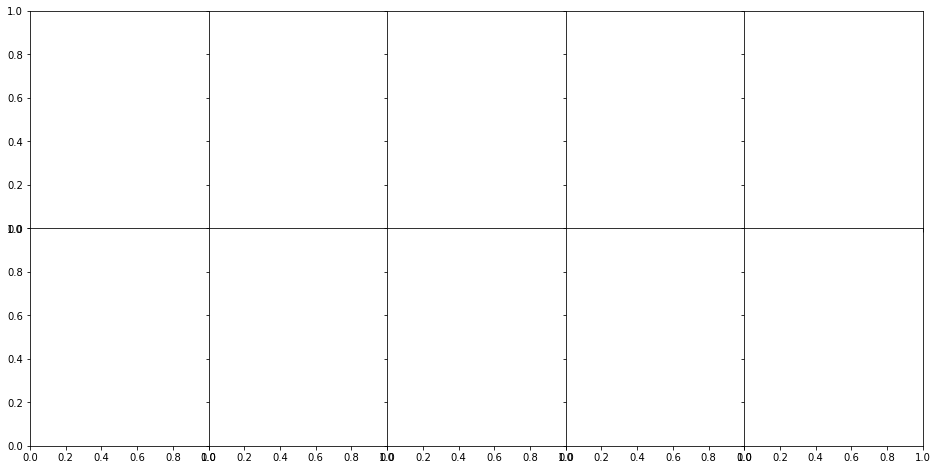

In [6]:
fig,ax = plt.subplots(2,5,sharey=True,sharex=True)
fig.set_size_inches(16,8)
fig.subplots_adjust(wspace=0,hspace=0)

amin,amax = -0.26,0.26
dbin = 0.02

xy = (0.8,0.90)

def plot_panel(ax,e1,e2):
    bins,hist,stats = MDF(e1,e2,data,amin,amax,diff=True,dbin=dbin)
    ax.step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
    ax.annotate('[' + e1 + '/' + e2 + ']', xy=xy, xycoords = 'axes fraction')
    ax.annotate('Median = %0.4f'%stats['median'], xy = (xy[0]-0.32,xy[1]-0.1), xycoords = 'axes fraction')
    ax.annotate('IQR = %0.4f'%stats['IQR'], xy = (xy[0]-0.32,xy[1]-0.2), xycoords = 'axes fraction')
    ax.annotate('f > 0.02 dex = %0.2f'%(1.0-stats['0.02dex']), xy=(xy[0]-0.32,xy[1]-0.3),xycoords='axes fraction')
    return

plot_panel(ax[(0,0)], 'C', 'H')
plot_panel(ax[(0,1)], 'N', 'H')
plot_panel(ax[(0,2)], 'O', 'H')
plot_panel(ax[(0,3)], 'Ne', 'H')
plot_panel(ax[(0,4)], 'Mg', 'H')
plot_panel(ax[(1,0)], 'Si', 'H')
plot_panel(ax[(1,1)], 'S', 'H')
plot_panel(ax[(1,2)], 'Ca', 'H')
plot_panel(ax[(1,3)], 'Fe', 'H')
plot_panel(ax[(1,4)], 'Mg', 'Fe')

for ax1 in ax:
    for ax2 in ax1:
        ax2.set_ylim(0,0.5)
        
ax[(0,0)].set_ylabel('Fraction')
ax[(1,0)].set_ylabel('Fraction')

for i in np.arange(5):
    ax[(1,i)].set_xlabel('FIRE - Age Abundance [dex]')
    

outname = simulation + '_stellar_MDFs_offset.png'
fig.savefig(outname)    

In [11]:
print("%8s  %8s %8s %8s %8s %8s %8s %8s %8s"%('Ratio','Median','IQR','Q1','Q3','f<0.05dex','f<0.02dex','f<0.01dex','f<0.005dex'))

i = 0
med = np.zeros((np.size(yield_model.elements)-2)*4)
iqr = np.zeros(np.size(med))
q1  = np.zeros(np.size(med))
q3  = np.zeros(np.size(med))
n01  = np.zeros(np.size(med))
n02  = np.zeros(np.size(med))
n005  = np.zeros(np.size(med))
n05  = np.zeros(np.size(med))

n = [None]*np.size(med)
d = [None]*np.size(med)
amin,amax = -5,2
dbin = 0.05

for denom in ['H','Fe','Mg','O']:
    for numerator in yield_model.elements:

        if numerator == 'Total' or numerator == 'He':
            continue
            
            
        bins,hist,stats = MDF(numerator,denom,data,amin,amax,diff=True,dbin=dbin)
        
        med[i] = stats['median']
        iqr[i] = stats['IQR']
        
        q1[i] = stats['Q1']
        q3[i] = stats['Q3']
        
        n[i] = numerator
        d[i] = denom
        
        n01[i] = stats['0.01dex']
        n02[i] = stats['0.02dex']
        n005[i] = stats['0.005dex']
        n05[i] = stats['0.05dex']
        
        
        print('[%2s/%2s]:  %8.4f %8.4f %8.4f %8.4f %8.4f %8.4f %8.4f %8.4f'%(n[i],d[i],med[i],iqr[i],q1[i],q3[i], n05[i], n02[i], n01[i], n005[i]))
        i = i + 1

   Ratio    Median      IQR       Q1       Q3 f<0.05dex f<0.02dex f<0.01dex f<0.005dex
[ C/ H]:    0.0267   0.0616  -0.0044   0.0572   0.6035   0.2619   0.1312   0.0658
[ N/ H]:    0.0518   0.1065  -0.0052   0.1013   0.3445   0.1357   0.0678   0.0342
[ O/ H]:    0.0004   0.0231  -0.0113   0.0119   0.9076   0.6913   0.4483   0.2476
[Ne/ H]:    0.0079   0.0230  -0.0043   0.0187   0.9071   0.6564   0.3725   0.1877
[Mg/ H]:    0.0076   0.0230  -0.0045   0.0185   0.9078   0.6585   0.3757   0.1894
[Si/ H]:    0.0056   0.0266  -0.0089   0.0177   0.8899   0.6300   0.3624   0.1866
[ S/ H]:    0.0050   0.0283  -0.0105   0.0177   0.8796   0.6129   0.3516   0.1819
[Ca/ H]:    0.0043   0.0299  -0.0122   0.0177   0.8689   0.5961   0.3415   0.1766
[Fe/ H]:    0.0002   0.0493  -0.0279   0.0214   0.7407   0.4378   0.2409   0.1248
[ C/Fe]:    0.0280   0.0758  -0.0078   0.0680   0.5468   0.2455   0.1248   0.0629
[ N/Fe]:    0.0553   0.1157  -0.0046   0.1111   0.3271   0.1307   0.0656   0.0328


KeyboardInterrupt: 

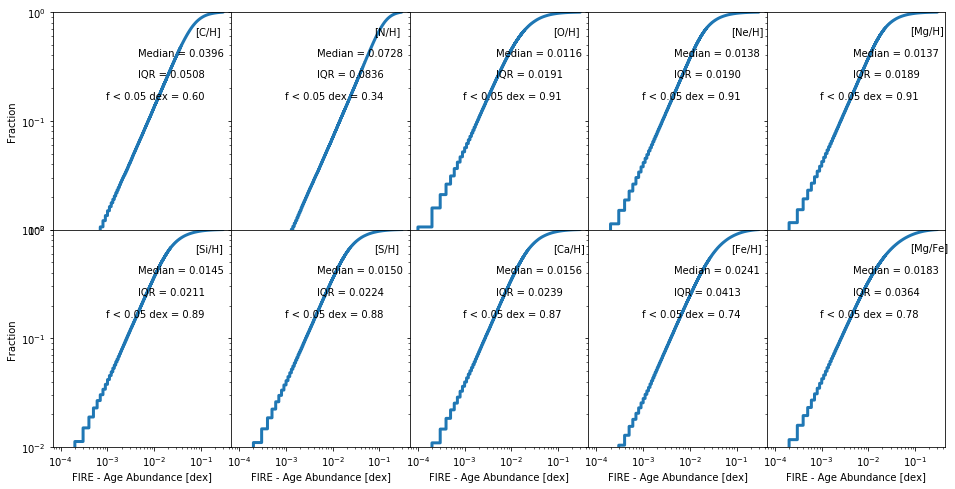

In [18]:
fig,ax = plt.subplots(2,5,sharey=True,sharex=True)
fig.set_size_inches(16,8)
fig.subplots_adjust(wspace=0,hspace=0)

amin,amax = 0.0, 0.3
dbin = 0.0001

xy = (0.8,0.90)

def plot_panel(ax,e1,e2):
    bins,hist,stats = MDF(e1,e2,data,amin,amax,diff=True,dbin=dbin,absval=True)
    
    
    ax.step(bins, np.cumsum(hist/(1.0*np.sum(hist))), where='post', lw = 3, color = 'C0')
    
    
    ax.annotate('[' + e1 + '/' + e2 + ']', xy=xy, xycoords = 'axes fraction')
    ax.annotate('Median = %0.4f'%stats['median'], xy = (xy[0]-0.32,xy[1]-0.1), xycoords = 'axes fraction')
    ax.annotate('IQR = %0.4f'%stats['IQR'], xy = (xy[0]-0.32,xy[1]-0.2), xycoords = 'axes fraction')
    ax.annotate('f < 0.05 dex = %0.2f'%(stats['0.05dex']), xy=(xy[0]-0.5,xy[1]-0.3),xycoords='axes fraction')
    return

plot_panel(ax[(0,0)], 'C', 'H')
plot_panel(ax[(0,1)], 'N', 'H')
plot_panel(ax[(0,2)], 'O', 'H')
plot_panel(ax[(0,3)], 'Ne', 'H')
plot_panel(ax[(0,4)], 'Mg', 'H')
plot_panel(ax[(1,0)], 'Si', 'H')
plot_panel(ax[(1,1)], 'S', 'H')
plot_panel(ax[(1,2)], 'Ca', 'H')
plot_panel(ax[(1,3)], 'Fe', 'H')
plot_panel(ax[(1,4)], 'Mg', 'Fe')

for ax1 in ax:
    for ax2 in ax1:
        ax2.set_ylim(1.0E-2,1.0)
        
        ax2.semilogy()
        ax2.semilogx()
        
ax[(0,0)].set_ylabel('Fraction')
ax[(1,0)].set_ylabel('Fraction')

for i in np.arange(5):
    ax[(1,i)].set_xlabel('FIRE - Age Abundance [dex]')
    

outname = simulation + '_cumulative_stellar_MDFs_offset.png'
fig.savefig(outname)    

In [ ]:
fig,ax=plt.subplots()
fig.set_size_inches(6,6)



ax.scatter(np.arange(np.size(med)), med)
ax.set_ylabel('Median Offset (dex)')

t= ax.set_xticks(np.arange(np.size(med)))

rat = [None]*len(n)
for i in np.arange(len(n)):
    rat[i] = '[%2s/%2s]'%(n[i],d[i])

t=ax.set_xticklabels(rat, fontsize=8)
plt.minorticks_on()

#fig.savefig('constFB_offset_fiducial.png')

In [ ]:
print(n)

In [ ]:
fig,ax = plt.subplots(2,5,sharey=True,sharex=True)
fig.set_size_inches(16,8)
fig.subplots_adjust(wspace=0,hspace=0)

amin,amax = -0.26,0.26
dbin = 0.02

xy = (0.8,0.90)

def plot_panel(ax,e1,e2):
    bins,hist,stats = MDF(e1,e2,data,amin,amax,diff=True,dbin=dbin,ptype='gas')
    ax.step(bins, hist/(1.0*np.sum(hist)), where='post', lw = 3, color = 'C0')
    ax.annotate('[' + e1 + '/' + e2 + ']', xy=xy, xycoords = 'axes fraction')
    ax.annotate('Median = %0.4f'%stats['median'], xy = (xy[0]-0.32,xy[1]-0.1), xycoords = 'axes fraction')
    ax.annotate('IQR = %0.4f'%stats['IQR'], xy = (xy[0]-0.32,xy[1]-0.2), xycoords = 'axes fraction')
    return

plot_panel(ax[(0,0)], 'C', 'H')
plot_panel(ax[(0,1)], 'N', 'H')
plot_panel(ax[(0,2)], 'O', 'H')
plot_panel(ax[(0,3)], 'Ne', 'H')
plot_panel(ax[(0,4)], 'Mg', 'H')
plot_panel(ax[(1,0)], 'Si', 'H')
plot_panel(ax[(1,1)], 'S', 'H')
plot_panel(ax[(1,2)], 'Ca', 'H')
plot_panel(ax[(1,3)], 'Fe', 'H')
plot_panel(ax[(1,4)], 'Mg', 'Fe')

for ax1 in ax:
    for ax2 in ax1:
        ax2.set_ylim(0,0.5)
        
ax[(0,0)].set_ylabel('Fraction')
ax[(1,0)].set_ylabel('Fraction')

for i in np.arange(5):
    ax[(1,i)].set_xlabel('FIRE - Age Abundance [dex]')
    

outname = simulation + '_gas_MDFs_offset.png'
fig.savefig(outname)    